Blog post related to this notebook: https://www.linkedin.com/pulse/pipeline-dreams-part-ii-creating-single-preprocessing-leah-fredman/

Here I am analyzing a cancer dataset from UCI that has only numeric features.
Althought it doesn't make that much sense to do here both PCA and Kmeans, I'm doing it just for practice sake.
As you'll see my custom transformer for feature engineering is not very sensible either, but I wanted to practice various feature transformations.
I'm not invested in the validity of this model, only in practicing data wrangling.

In [3]:
#importing the csv directly from the web as a pandas dataframe, and naming the columns since the headers with the CSV weren't what I wanted, so I instructed it to not import
import pandas as pd
df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", header = None, names=['ID', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'y'], usecols=['ID', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'y'])

In [4]:
#Checking the first 5 lines of the dataframe
print(df1.head())
#Checking variable types
print(df1.dtypes)
#Checking some descriptive stats for the numeric variable in the dataframe
print(df1.describe())

        ID  x1  x2  x3  x4  x5  x6  x7  x8  x9  y
0  1000025   5   1   1   1   2   1   3   1   1  2
1  1002945   5   4   4   5   7  10   3   2   1  2
2  1015425   3   1   1   1   2   2   3   1   1  2
3  1016277   6   8   8   1   3   4   3   7   1  2
4  1017023   4   1   1   3   2   1   3   1   1  2
ID     int64
x1     int64
x2     int64
x3     int64
x4     int64
x5     int64
x6    object
x7     int64
x8     int64
x9     int64
y      int64
dtype: object
                 ID          x1          x2          x3          x4  \
count  6.990000e+02  699.000000  699.000000  699.000000  699.000000   
mean   1.071704e+06    4.417740    3.134478    3.207439    2.806867   
std    6.170957e+05    2.815741    3.051459    2.971913    2.855379   
min    6.163400e+04    1.000000    1.000000    1.000000    1.000000   
25%    8.706885e+05    2.000000    1.000000    1.000000    1.000000   
50%    1.171710e+06    4.000000    1.000000    1.000000    1.000000   
75%    1.238298e+06    6.000000    5.000000   

In [5]:
#Splitting the data and then cleaning the training dataframe
from sklearn.model_selection import train_test_split

df1_train_full, test_full = train_test_split(df1, test_size=0.2)

In [6]:
#using dfply to see whether IDs appear more than once and removing them if they do because its unclear where the issue is
from dfply import *
dup_id = (df1_train_full >>
         summarize(distinct_id_sum = n_distinct(X.ID), id_sum = n(X.ID)) )
print(dup_id)

   distinct_id_sum  id_sum
0              519     559


In [7]:
#There are some duplicates so I'll drop them with dfply
df1_train_full = (df1_train_full >>
     distinct(X.ID))


#Removing the target
df1_train = df1_train_full >> drop(X.y)

In [8]:
#x6 was listed as dtype object above, while others are integer
#Therefore electing and listing the distinct values of x6 to see which if any aren't numeric using the dfply package with piping
print(df1_train >> select(X.x6) >> distinct(X.x6))
#We see that 6 has a "?" in it, maybe more than one

     x6
353  10
649   1
40    ?
605   8
696   3
247   9
427   2
455   6
403   4
482   5
359   7


In [9]:
#To see how many times each of these values appears:
print(df1_train["x6"].value_counts())
#We see there are 16 "?" in the dataframe, and considering the size of it, it's not that bad, so I'll probably convert them and impute their values

1     278
10    106
3      26
2      25
5      18
4      17
8      16
?      12
9       9
7       8
6       4
Name: x6, dtype: int64


In [10]:
#Cleaning data so that it's all numeric and all "?" become NaNs
#Making it float32 because I don't need 64 and it takes up less space this way
import numpy as np
df1_train = df1_train.apply(pd.to_numeric, errors = 'coerce').astype(np.float32)

In [11]:
#Checking the first 5 lines of the dataframe
print(df1_train.head())
#Checking variable types
print(df1_train.dtypes)
#Checking some descriptive stats for the numeric variable in the dataframe
print(df1_train.describe())
#Every column has a count of 516 except x6, which means its the the only one with NAs

            ID    x1   x2    x3    x4    x5    x6   x7   x8   x9
353   850831.0   2.0  7.0  10.0  10.0   7.0  10.0  4.0  9.0  4.0
649  1318671.0   3.0  1.0   1.0   1.0   2.0   1.0  2.0  1.0  1.0
600  1336798.0   3.0  1.0   1.0   1.0   2.0   1.0  2.0  1.0  1.0
201  1216694.0  10.0  8.0   8.0   4.0  10.0  10.0  8.0  1.0  1.0
40   1096800.0   6.0  6.0   6.0   9.0   6.0   NaN  7.0  8.0  1.0
ID    float32
x1    float32
x2    float32
x3    float32
x4    float32
x5    float32
x6    float32
x7    float32
x8    float32
x9    float32
dtype: object
                 ID          x1          x2          x3          x4  \
count  5.190000e+02  519.000000  519.000000  519.000000  519.000000   
mean   1.069882e+06    4.556840    3.277457    3.352601    3.000000   
std    6.168626e+05    2.892565    3.068727    3.002723    2.993558   
min    6.163400e+04    1.000000    1.000000    1.000000    1.000000   
25%    8.680765e+05    2.000000    1.000000    1.000000    1.000000   
50%    1.170945e+06    4.00000

In [12]:
#Seeing whether any columns have null values. It seems that only x6 does
df1_train.isnull().sum()

ID     0
x1     0
x2     0
x3     0
x4     0
x5     0
x6    12
x7     0
x8     0
x9     0
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

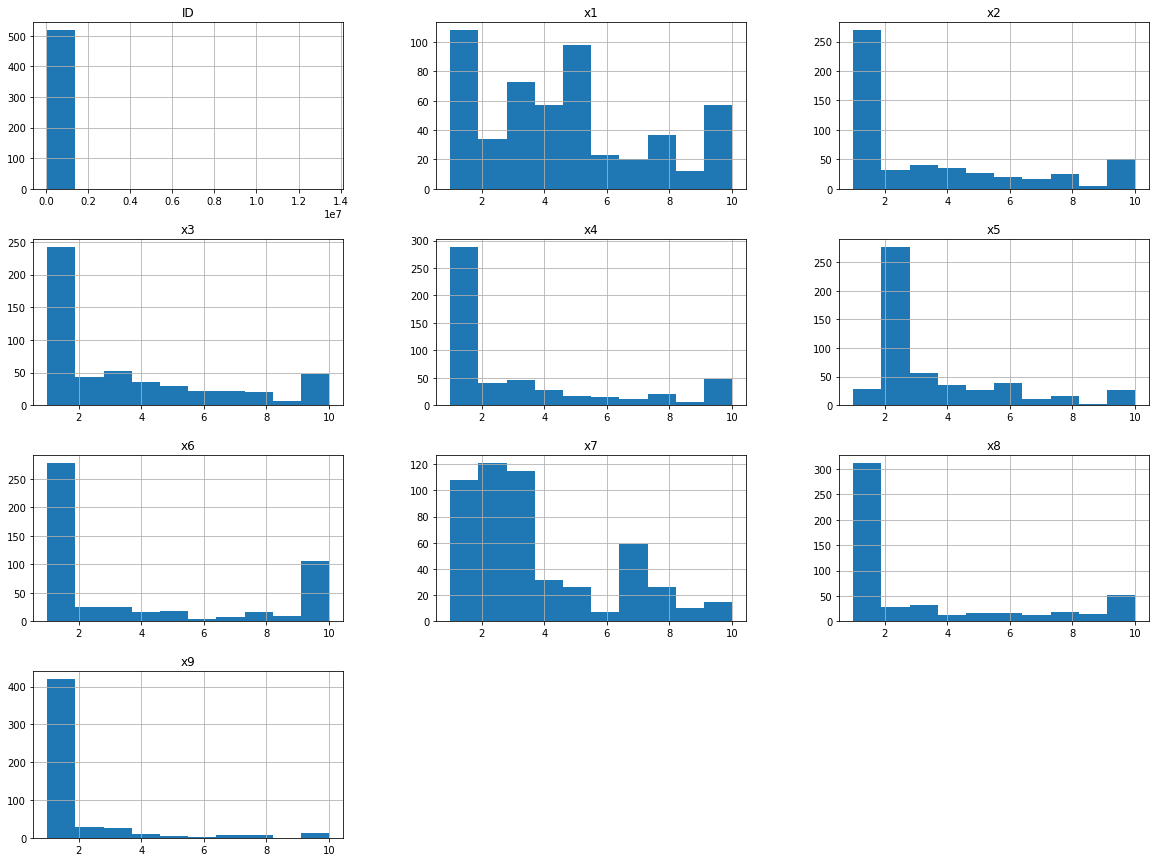

In [13]:
#histogram plot
%matplotlib inline
import matplotlib.pyplot as plt
df1_train.hist(bins = 10, figsize = (20, 15))
plt.show
#Seeing all the variables that are mostly a single value, and then the other values are very small and pretty equally spread out, it might pay to dichotomize those, which could be done very easily with dfply, mutate, and an if else statement, but for now I'm skipping it
#Additionally, you can clearly see that the classes are very imbalanced

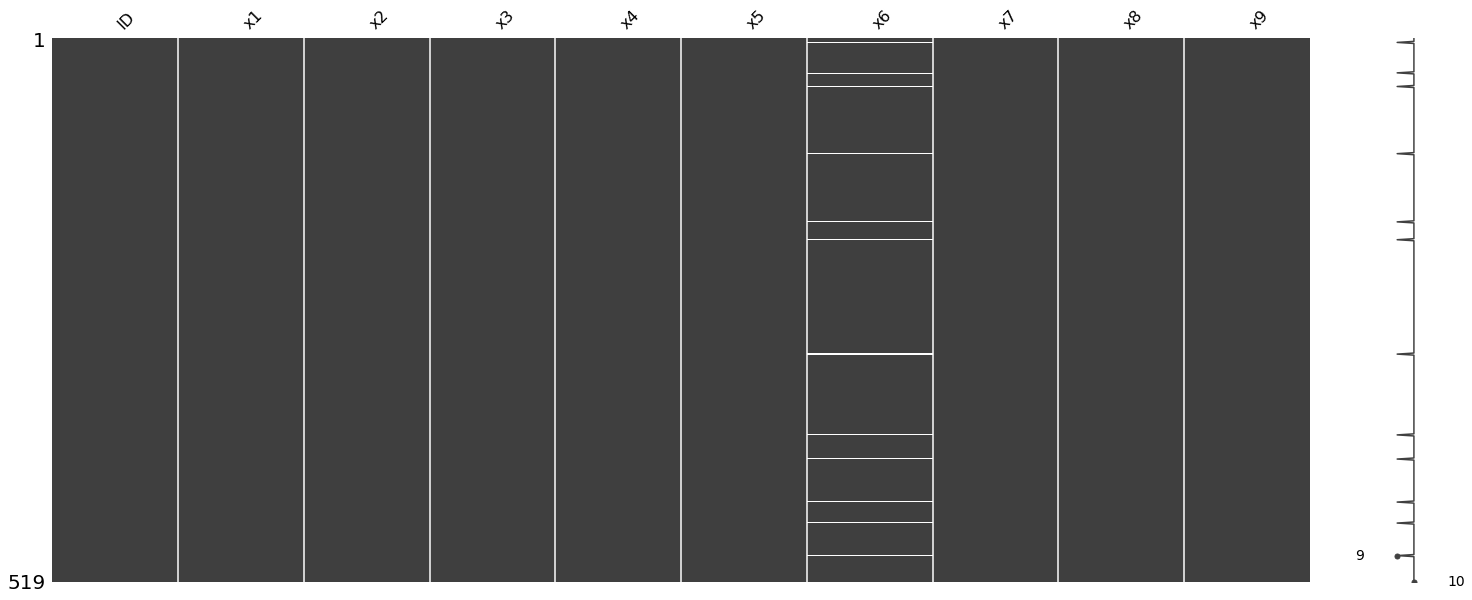

In [14]:
#white lines indicate where missing data is
#https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce
import missingno as msno

msno.matrix(df1_train)

,Total,Percent
x6,12,2.312139
x9,0,0.000000
x8,0,0.000000
x7,0,0.000000
x5,0,0.000000


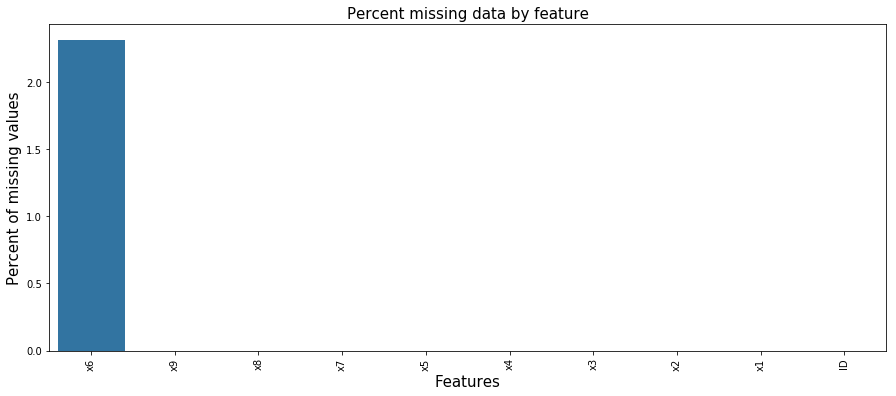

In [15]:
#Getting the number of missing values per column, as well as what percentage that number represents
#Plotting these findings
import seaborn as sns
total = df1_train.isnull().sum().sort_values(ascending=False)
percent = (df1_train.isnull().sum()/df1_train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [40]:
#Before we do anything else like feature engineering or dimension reduction we want to first deal with the missing data, so that's our first step in our pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
#As I keep adding data cleaning steps they will continue to go into this pipeline
#I'll creat a dataset with only the numeric features, and w/o the targets (which I've previously removed)
df_train_x = df1_train >> drop(X.ID)

#Naming my pipeline numeric_pipe, and then defining it with calling the Imputer "imputer", and specifying that I want the mean (I could choose something else, like the median):
# code looks like this:
                  #numeric_pipe1 = Pipeline([('imputer', Imputer(strategy="mean"))])

#We now fit (aka train) the pipeline on the data, and then transform it every step of the way after each fitting, and save the result:
# code looks like this:
                  #train_df_tr1 = numeric_pipe1.fit_transform(df_train_x)

In [17]:
#If we want to feature engineer we can do it now after we've handled missing data
#With this dataset there it does not really make sense to engineer anything other than what I discussed above, since it would be random, 
#but I want to do so for practice purposes
#For practice I am going to dichotomize x9 into score of 1 or score above one
#and create a ratio of x7 to x3
#For this I create a custom transformer:
from sklearn.base import BaseEstimator, TransformerMixin

x3_ix, x7_ix, x9_ix = 2, 6, 8

class CombinedAttributesAdder1(BaseEstimator, TransformerMixin):
    def __init__(self, add_x3_to_x7 = True): # no *args or **kargs
        self.add_x3_to_x7 = add_x3_to_x7
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        lambda_x9 = lambda x: 0 if x < 2 else 1 #using .apply and then a lambda doesn't work with np arrays, only pandas dataframes
        vlambda = np.vectorize(lambda_x9) #this is a good substitute to the .apply
        x9_dich = vlambda(X[:, x9_ix])
        if self.add_x3_to_x7:
            x3_to_x7 = X[:, x3_ix] / X[:, x7_ix]
            return np.c_[X, x9_dich, x3_to_x7]
        else:
            return np.c_[X, x9_dich]

In [18]:
attr_adder1 = CombinedAttributesAdder1(add_x3_to_x7=False)
df_extra_attribs1 = attr_adder1.transform(df_train_x.values)

In [19]:
#So now our pipeline is as follows
# code looks like this:
                  #numeric_pipe = Pipeline([('imputer', Imputer(strategy="mean")),
    #                       ('attribs_adder1', CombinedAttributesAdder1())])


In [20]:
#The features are all on the same scale, so feature scaling isn't really necessary but I'm doing it anyways

from sklearn.preprocessing import StandardScaler

In [21]:
#So now our pipeline is as follows
# code looks like this:
                  #numeric_pipe = Pipeline([('imputer', Imputer(strategy="mean")),
    #                       ('attribs_adder1', CombinedAttributesAdder1()),
    #                        ('std_scaler', StandardScaler())])

In [42]:
#######################Playing around with PCA############################
#PCA is affected by scale so scale the features first

#To determine how many components we want, we'll examine a scree plot
#This means we need a copy of the imputed and standardized data first:
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                         ('attribs_adder1', CombinedAttributesAdder1()),
                         ('std_scaler', StandardScaler())])
train_df_tr = numeric_pipe.fit_transform(df_train_x)
train_df_tr_pd = pd.DataFrame(train_df_tr)
train_df_tr_pd.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.884788,1.214229,2.215924,2.340611,1.567510,1.694919,0.168907,1.846223,1.255370,2.046949,2.252880
1,-0.538740,-0.742867,-0.784245,-0.668746,-0.593855,-0.754848,-0.628028,-0.654762,-0.366714,-0.488532,-0.720010
2,-0.538740,-0.742867,-0.784245,-0.668746,-0.593855,-0.754848,-0.628028,-0.654762,-0.366714,-0.488532,-0.720010
3,1.883591,1.540411,1.549220,0.334373,2.864328,1.694919,1.762779,-0.654762,-0.366714,-0.488532,0.023212
4,0.499402,0.888046,0.882516,2.006238,1.135237,0.000000,1.364311,1.533600,-0.366714,-0.488532,-0.189137


In [23]:
#############This is great to learn about PCA, but you don't need to actually run it for our purposes/pipeline
#Deciding what size we want the new dimension to be
#"https://plot.ly/ipython-notebooks/principal-component-analysis/"
#Computing eigenvectors (the principal components) of a dataset that determine directions of new feature space
#collecting them in a projection matrix. 
#Each eigenvectors is associated with an eigenvalue which can be interpreted as length/magnitude of corresponding eigenvector
#If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA by dropping "less informative" eigenpairs is reasonable
#the eigenvalues explain the variance of the data along the new feature axes.
import numpy as np
#manually computing covatiance matrix:
mean_vec = np.mean(train_df_tr_pd, axis=0)
cov_mat = (train_df_tr_pd - mean_vec).T.dot((train_df_tr_pd - mean_vec)) / (train_df_tr_pd.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

#Using numpy cov function to compute covariance matrix:
print('NumPy covariance matrix: \n%s' %np.cov(train_df_tr_pd.T))

#Eigendecomposition on the covariance matrix:
cov_mat = np.cov(train_df_tr_pd.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

#Especially, in the field of "Finance," the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix. Eigendecomposition of the standardized data based on the correlation matrix:
cor_mat1 = np.corrcoef(train_df_tr_pd.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

#Eigendecomposition of the correlation matrix after standardizing the data is the same as well:
#cor_mat2 = np.corrcoef(dataframe_name.T)

#eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

#While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency:
u,s,v = np.linalg.svd(train_df_tr_pd.T)
u

#eigenvectors only define the directions of the new axis, since they have all the same unit length 
#In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues
#eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data
#ranking the eigenvalues from highest to lowest in order choose the top k eigenvectors
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Covariance matrix 
          0         1         2         3         4         5         6   \
0   1.001931  0.654763  0.656747  0.485396  0.539140  0.590152  0.575114   
1   0.654763  1.001931  0.906861  0.684509  0.766019  0.670673  0.763791   
2   0.656747  0.906861  1.001931  0.673733  0.735126  0.694337  0.743790   
3   0.485396  0.684509  0.673733  1.001931  0.588207  0.667062  0.661554   
4   0.539140  0.766019  0.735126  0.588207  1.001931  0.563309  0.607265   
5   0.590152  0.670673  0.694337  0.667062  0.563309  1.001931  0.691790   
6   0.575114  0.763791  0.743790  0.661554  0.607265  0.691790  1.001931   
7   0.547327  0.734555  0.713747  0.584415  0.625520  0.569414  0.678588   
8   0.376015  0.483586  0.455088  0.411847  0.487500  0.356244  0.351129   
9   0.459559  0.511312  0.467866  0.454995  0.456224  0.449906  0.406442   
10  0.290070  0.346775  0.489693  0.178291  0.304844  0.201330 -0.099498   

          7         8         9         10  
0   0.547327  0.376015 

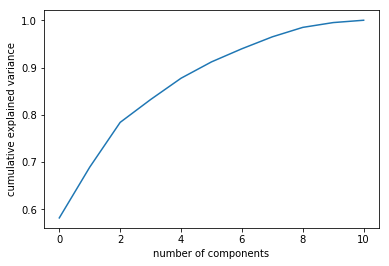

In [43]:
#This we do want to run for the pipeline, to determine ahead of time how many components we want
#A scree plot displays the variance explained by each principal component within the analysis
#cumulative explained variance ratio as a function of the number of components
from sklearn.decomposition import PCA

pca = PCA().fit(train_df_tr_pd)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#fig = plt.figure(figsize = (30, 25))
plt.show()

In [44]:
#following dimensionality reduction each principal component doesn't really have a meaning 
#The new components are just the seven main dimensions of variation based on the above scree plot
#We don't need all this for the pipeline, but this is good to see how to run a PCA outside a pipline
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
principalComponents = pca.fit_transform(train_df_tr_pd)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7'])
#Resetting index to avoid issues further down with concat
principalDf = principalDf.reset_index(drop=True)
print(principalDf.head())

        pc1       pc2       pc3       pc4       pc5       pc6       pc7
0  4.543595  1.792197  0.247389 -1.724945  1.826309 -1.023760 -0.397735
1 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124
2 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124
3  3.369214 -1.280069  1.550079  0.482274 -0.526608  2.618206 -0.678145
4  2.458236 -1.472648  0.783855 -1.035092 -0.061921 -0.281642  1.274952


In [26]:
#If you want you can save your components in a new dataframe together with your target
#Concatenating DataFrame along axis = 1. 
#finalDf is the final DataFrame with the PCs
#We didn't create a dataframe with just the target yet because we didn't need it for the pipeline
#But obviously if you want to concatenate them you need to make one first
target_dataframe_name = df1_train_full >> select(X.y)
target_dataframe_name = pd.DataFrame(target_dataframe_name)
target_dataframe_name = target_dataframe_name.reset_index(drop=True)
#Specifying axis = 1 so that it adds the dataframes horizontally
final_df = pd.concat([principalDf, target_dataframe_name], axis=1)
print(final_df.head())

        pc1       pc2       pc3       pc4       pc5       pc6       pc7  y
0  4.543595  1.792197  0.247389 -1.724945  1.826309 -1.023760 -0.397735  4
1 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124  2
2 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124  2
3  3.369214 -1.280069  1.550079  0.482274 -0.526608  2.618206 -0.678145  4
4  2.458236 -1.472648  0.783855 -1.035092 -0.061921 -0.281642  1.274952  2


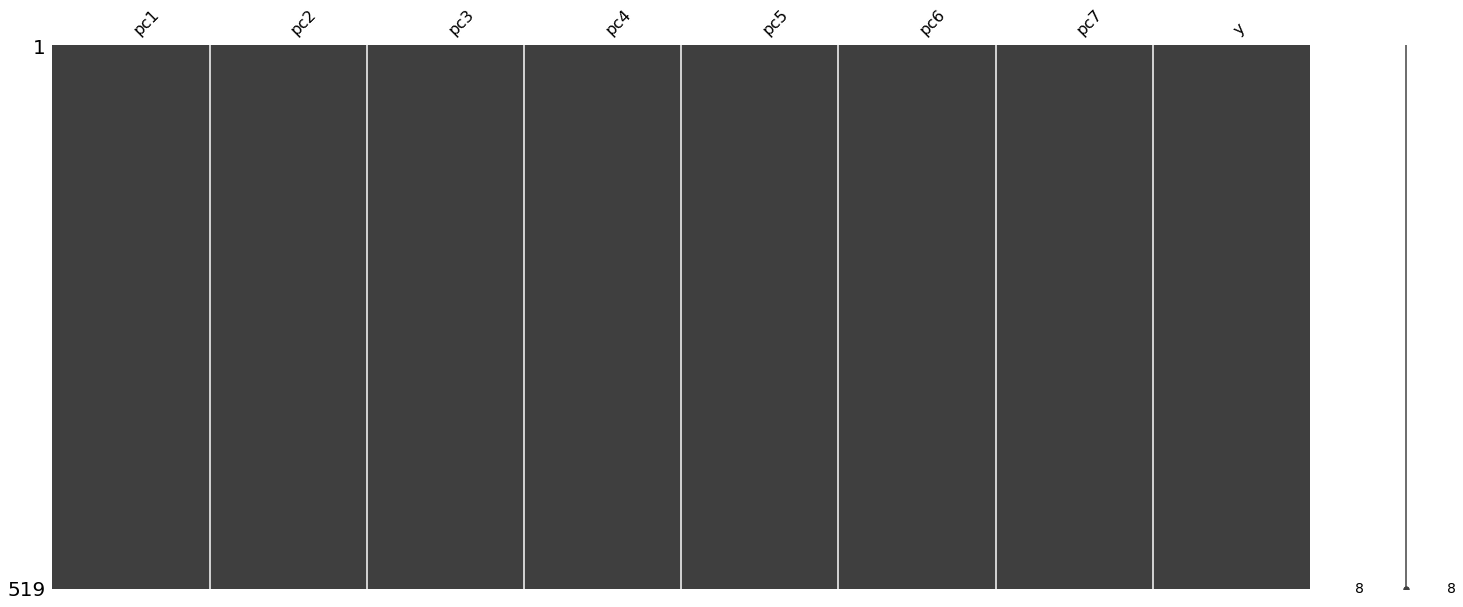

In [27]:
msno.matrix(final_df)

In [28]:
#######################Playing with K-means with PCAed data####################
#To determine how many clusters we want, we need the PCAed data:
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                         ('attribs_adder1', CombinedAttributesAdder1()),
                         ('std_scaler', StandardScaler()),
                         ('pca', PCA(n_components = 7))])
train_df_tr = numeric_pipe.fit_transform(df_train_x)
clust_data = pd.DataFrame(train_df_tr)
print(clust_data.head())
#Finding optimal no. of clusters

from sklearn.cluster import KMeans
import sklearn.metrics
 
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

          0         1         2         3         4         5         6
0  4.543595  1.792197  0.247389 -1.724945  1.826309 -1.023760 -0.397735
1 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124
2 -2.075251 -0.215641 -0.338978 -0.009745 -0.181949  0.126202  0.078124
3  3.369214 -1.280069  1.550079  0.482274 -0.526608  2.618206 -0.678145
4  2.458236 -1.472648  0.783855 -1.035092 -0.061921 -0.281642  1.274952


In [29]:
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(clust_data)
    prediction = model.predict(clust_data)
    meanDistortions.append(sum(np.min(cdist(clust_data, model.cluster_centers_, 'euclidean'), axis=1)) / clust_data.shape[0])

Text(0.5,1,'Selecting k with the Elbow Method')

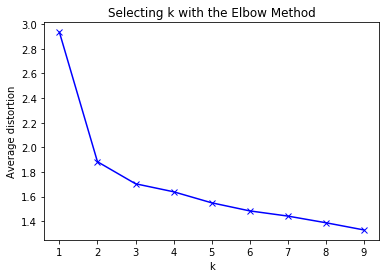

In [30]:
#plt.cla()
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [31]:
#actual clustering for 2
#add the cluster ID to the original dataset
#We probably don't need this for the pipeline, but could be interesting for graphing and exploratory data analysis
final_model1 = KMeans(2)
final_model1.fit(clust_data)
prediction1 = final_model1.predict(clust_data)

In [32]:
final_df_train1 = df1_train_full >> drop(X.ID)
final_df_train1["GROUP"] = prediction1


final_df_train1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y,GROUP
353,2,7,10,10,7,10,4,9,4,4,0
649,3,1,1,1,2,1,2,1,1,2,1
600,3,1,1,1,2,1,2,1,1,2,1
201,10,8,8,4,10,10,8,1,1,4,0
40,6,6,6,9,6,?,7,8,1,2,0


Groups Assigned : 

     x1  x2  x3  x4  x5  x6  x7  x8  x9  y  GROUP
353   2   7  10  10   7  10   4   9   4  4      0
649   3   1   1   1   2   1   2   1   1  2      1
600   3   1   1   1   2   1   2   1   1  2      1
201  10   8   8   4  10  10   8   1   1  4      0
40    6   6   6   9   6   ?   7   8   1  2      0
323   5   4   6  10   2  10   4   1   1  4      0
587   5   1   1   1   2   1   2   2   1  2      1
38    5   4   4   9   2  10   5   6   1  4      0
402   5   3   3   1   2   1   2   1   1  2      1
213  10  10  10  10   7  10   7  10   4  4      0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000298BCF46CF8>,
      dtype=object)

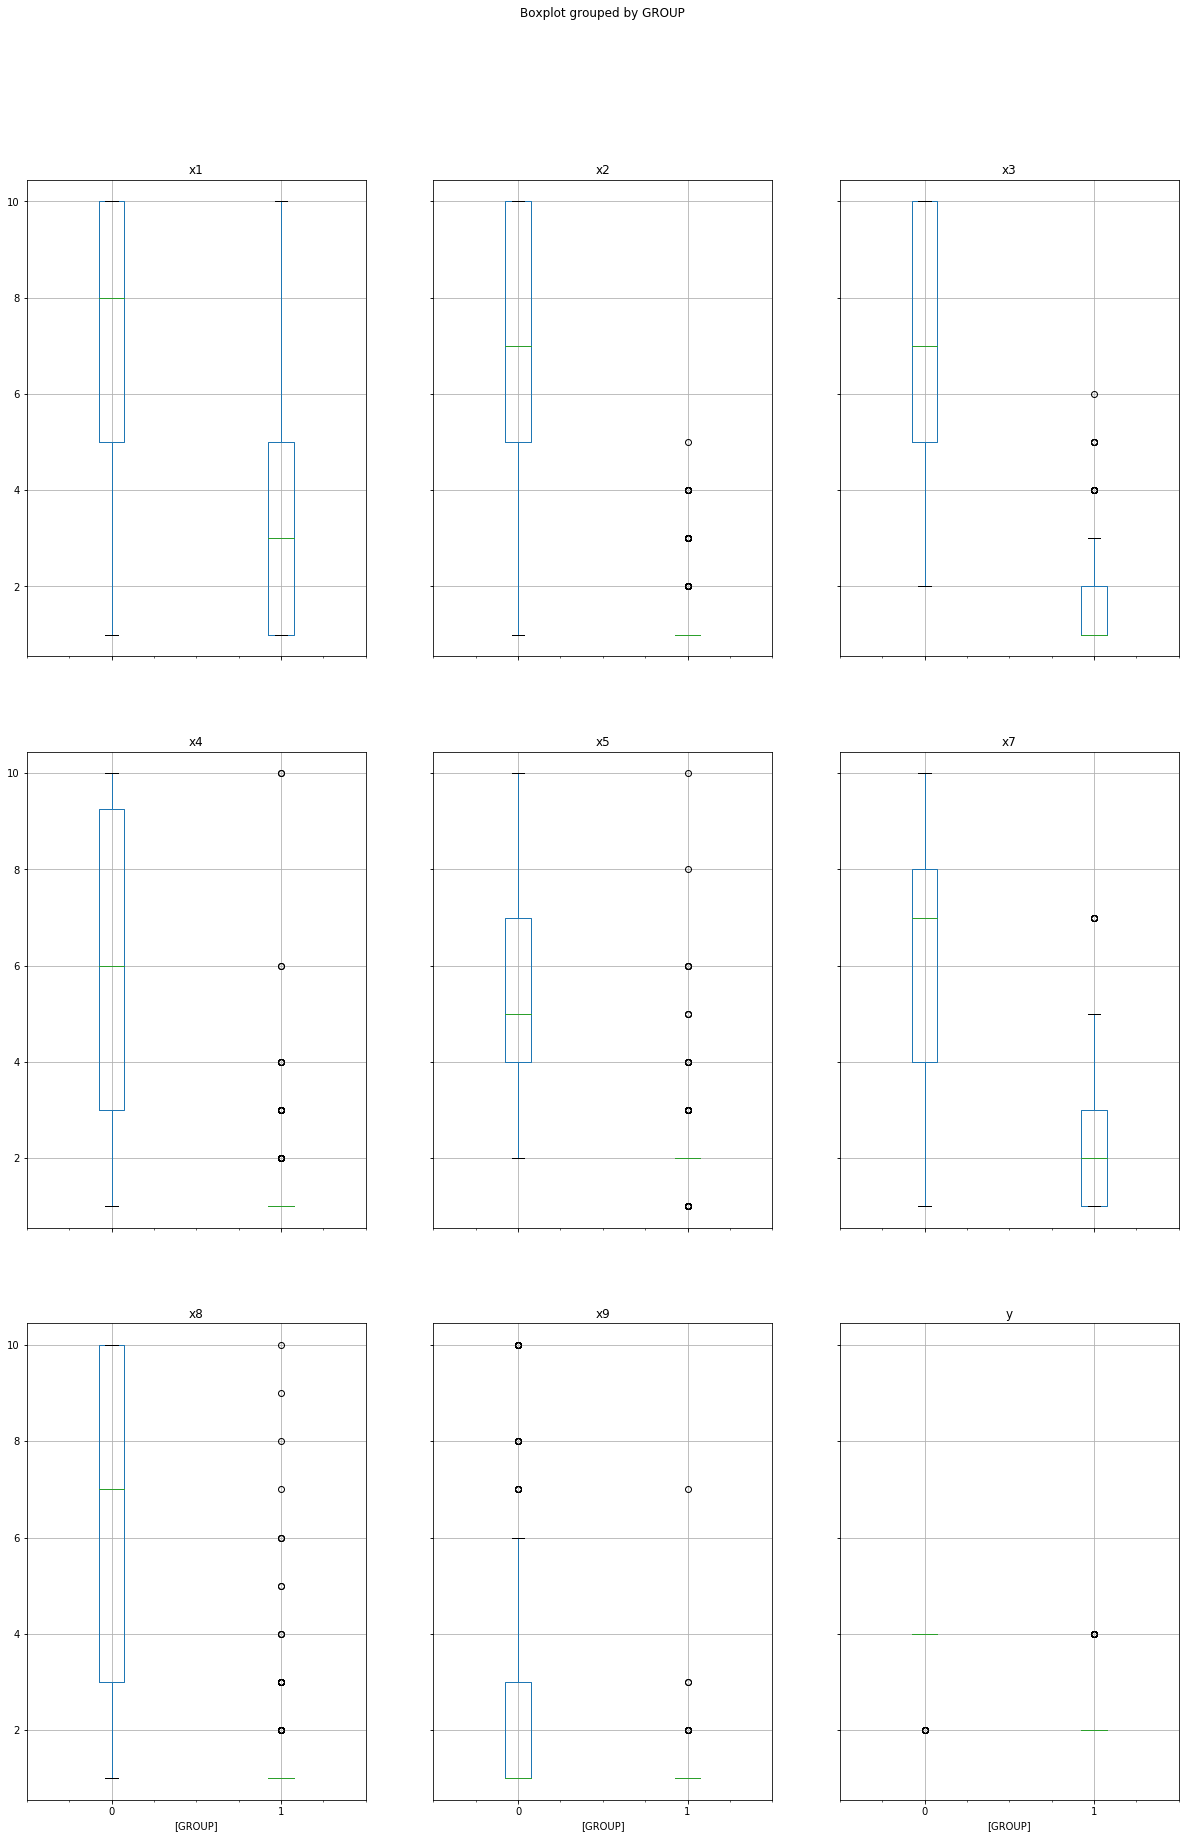

In [33]:
#Join predicted clusters to dataframe
final_df_train1 = df1_train_full >> drop(X.ID)
final_df_train1["GROUP"] = prediction1
print("Groups Assigned : \n")
print(final_df_train1.head(10))

#set of boxplots to see how the groups differ for various feature attributes
import matplotlib.pyplot as plt

final_df_train1.boxplot(by="GROUP", figsize=(20,30))

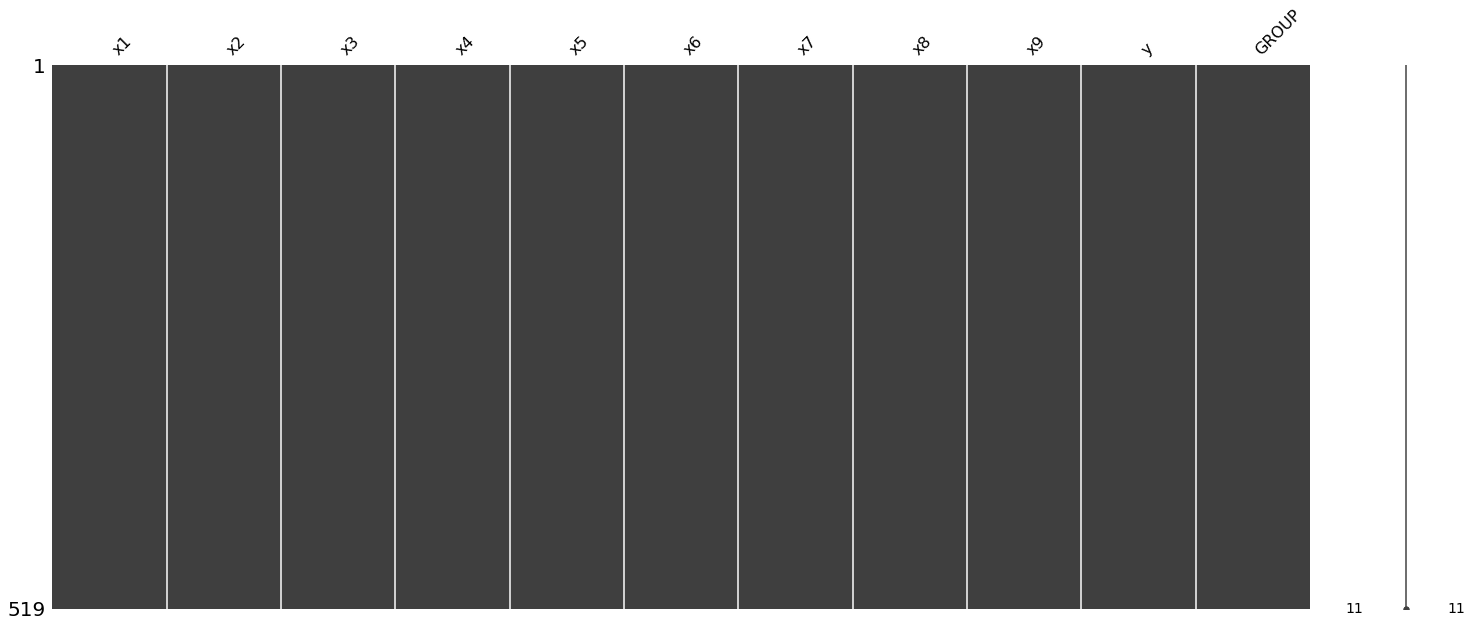

In [34]:
msno.matrix(final_df_train1)

In [35]:
#If we run the pipeline now as is the output will be two columns with each point's relation to each of the k points
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                         ('attribs_adder1', CombinedAttributesAdder1()),
                         ('std_scaler', StandardScaler()),
                         ('pca', PCA(n_components = 7)),
                         ('kmean', KMeans(n_clusters = 2))])
train_df_tr = numeric_pipe.fit_transform(df_train_x)
train_df_tr_pd = pd.DataFrame(train_df_tr)
train_df_tr_pd.head()


,0,1
0,3.660524,7.044206
1,5.215423,0.590033
2,5.215423,0.590033
3,3.362656,6.167650
4,2.357878,4.817431


In [36]:
#If we want a single column as an output we need to transform the data
#For this I create a custom transformer:
from sklearn.base import BaseEstimator, TransformerMixin

k1_ix, k2_ix = 0, 1

class CombinedAttributesAdder2(BaseEstimator, TransformerMixin):
    def __init__(self, add_create_groups = True): # no *args or **kargs
        self.add_create_groups = add_create_groups
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        group = X[:, k1_ix] - X[:, k2_ix]
        lambda_group = lambda x: 0 if x > 0 else 1 #using .apply and then a lambda doesn't work with np arrays, only pandas dataframes
        vlambda = np.vectorize(lambda_group) #this is a good substitute to the .apply
    
        if self.add_create_groups:
            group = vlambda(group)
            return np.c_[group]
        else:
            return np.c_[X]
        
attr_adder2 = CombinedAttributesAdder2(add_create_groups=False)

In [37]:
#If we run the pipeline with what we have now:
#The final pipline:
numeric_pipe = Pipeline([('imputer', SimpleImputer(strategy="mean")),
                         ('attribs_adder1', CombinedAttributesAdder1()),
                         ('std_scaler', StandardScaler()),
                         ('pca', PCA(n_components = 7)),
                         ('kmean', KMeans(n_clusters = 2)),
                         ('attribs_adder2', CombinedAttributesAdder2())])
train_df_tr = numeric_pipe.fit_transform(df_train_x)
train_df_tr_pd = pd.DataFrame(train_df_tr)
train_df_tr_pd.head(10)
#We get instead of one column with groups two columns with the values associated with each k, so we want to transform that
#We can do that with another custom transformer

,0
0,0
1,1
2,1
3,0
4,0
5,0
6,1
7,0
8,1
9,0
